In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

In [2]:
# Function to count classes in the dataset
def Classes_Count(path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

In [3]:
# Data paths
train_dir = r'C:\Users\ELANGO S\project_data\train'
test_dir = r'C:\Users\ELANGO S\project_data\test'

In [4]:
# Count classes in train and test datasets
Train_Count = Classes_Count(train_dir, 'train').transpose().sort_values(by="train", ascending=False)
Test_Count = Classes_Count(test_dir, 'test').transpose().sort_values(by="test", ascending=False)
pd.concat([Train_Count, Test_Count], axis=1)

,train,test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


In [5]:
# Image parameters
img_shape = 224
batch_size = 64

In [6]:
# ImageDataGenerator for train and test data
train_preprocessor = ImageDataGenerator( 
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_preprocessor = ImageDataGenerator(rescale=1 / 255.)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Load pre-trained ResNet50V2 model
ResNet50V2_base = ResNet50V2(input_shape=(img_shape, img_shape, 3),
                             include_top=False,
                             weights='imagenet'
                             )

# Freeze all layers except last 50
ResNet50V2_base.trainable = True
for layer in ResNet50V2_base.layers[:-50]:
    layer.trainable = False

# Custom model using ResNet50V2
def Create_Custom_ResNet50V2_Model():
    model = Sequential([
        ResNet50V2_base,
        Dropout(0.25),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

ResNet50V2_Model = Create_Custom_ResNet50V2_Model()
ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [8]:
# Callbacks
checkpoint_path = "ResNet50V2_Model_Checkpoint.keras"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [9]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data, validation_data=test_data, epochs=30, batch_size=batch_size,
                                           callbacks=callbacks, steps_per_epoch=steps_per_epoch,
                                           validation_steps=validation_steps)

Epoch 1/30


C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 11890s 26s/step - accuracy: 0.4148 - loss: 1.8161 - val_accuracy: 0.4235 - val_loss: 1.8775 - learning_rate: 0.0010
Epoch 2/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 49:13 7s/step - accuracy: 0.5469 - loss: 1.4072

C:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5469 - loss: 1.4072 - val_accuracy: 0.8000 - val_loss: 0.7172 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4255s 9s/step - accuracy: 0.5465 - loss: 1.2725 - val_accuracy: 0.5831 - val_loss: 1.1432 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.6562 - loss: 1.2040 - val_accuracy: 0.9000 - val_loss: 0.5253 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 8671s 19s/step - accuracy: 0.5889 - loss: 1.1575 - val_accuracy: 0.6053 - val_loss: 1.1213 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6406 - loss: 1.1386 - val_accuracy: 0.7000 - val_loss: 0.4412 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 3801s 8s/step - accuracy: 0.6129 - loss: 1.0749 - val_accuracy: 0.5617 - val_loss: 1.5900 - learning_rate: 0.0010
Epoch 8/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 53:30 7s/step - accuracy: 0.5000 - loss: 1.034

In [10]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)
print("Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))


113/113 ━━━━━━━━━━━━━━━━━━━━ 452s 4s/step - accuracy: 0.4576 - loss: 1.3646
Test Loss: 1.14776
Test Accuracy: 58.28%


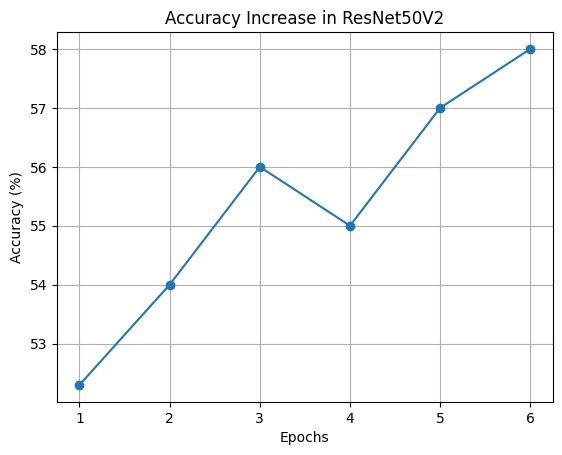

In [1]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6]  # Assuming 6 epochs
accuracy_values = [52.3, 54, 56, 55, 57, 58]

plt.plot(epochs, accuracy_values, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Increase in ResNet50V2')
plt.xticks(epochs)
plt.grid(True)
plt.show()

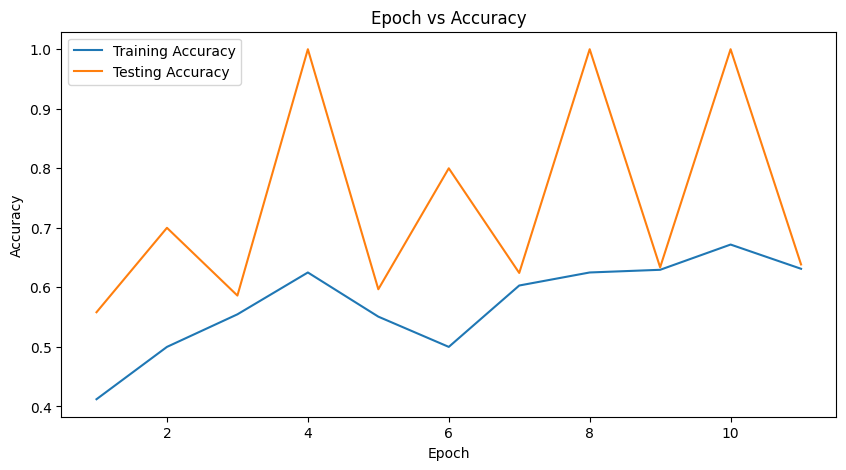

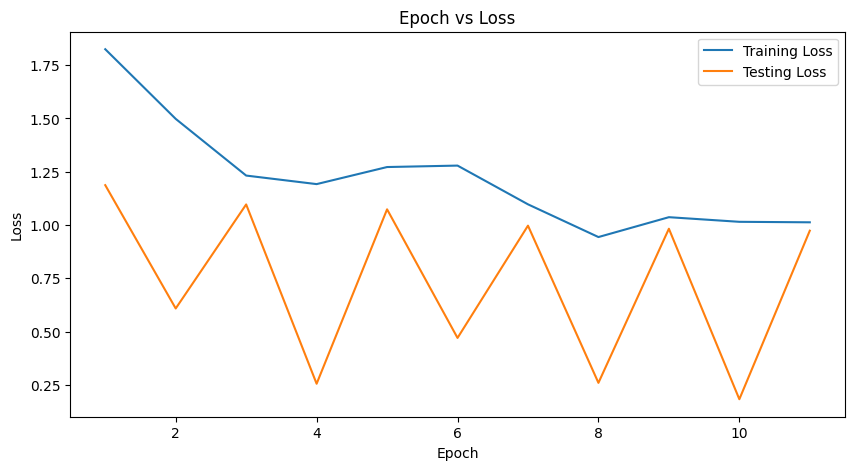

In [7]:
import matplotlib.pyplot as plt

# Define the training and testing history 
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
train_accuracy = [0.4121, 0.5, 0.5547, 0.625, 0.5508, 0.5, 0.6031, 0.625, 0.6295, 0.6719, 0.6312]
train_loss = [1.8249, 1.4981, 1.2321, 1.192, 1.2721, 1.2789, 1.0971, 0.9436, 1.0368, 1.0151, 1.0128]
test_accuracy = [0.5582, 0.7, 0.5862, 1.0, 0.5968, 0.8, 0.6242, 1.0, 0.6336, 1.0, 0.6385]
test_loss = [1.1871, 0.6085, 1.0966, 0.2553, 1.0737, 0.4703, 0.9971, 0.2595, 0.9826, 0.1827, 0.9735]

# Plotting epoch vs training accuracy and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, test_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.show()

# Plotting epoch vs training loss and testing loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, test_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define the directory path where your test data is located
test_data_dir = r'C:\Users\ELANGO S\project_data\test'

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # You can add other preprocessing steps here if needed

# Load test data using flow_from_directory
test_data_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # Adjust the target size to match your model's input size
    batch_size=16,
    class_mode='categorical',  # Use 'categorical' for classification problems
    shuffle=False  # Important: set shuffle to False for test data to keep labels in order
)

# Concatenate the batches to get the full test data and labels
test_data_array = []
test_labels = []

for i in range(len(test_data_generator)):
    data, labels = test_data_generator[i]
    test_data_array.append(data)
    test_labels.append(labels)

test_data_array = np.concatenate(test_data_array)
test_labels = np.concatenate(test_labels)

# Print the shape of test data and labels to verify
print('Test data shape:', test_data_array.shape)
print('Test labels shape:', test_labels.shape)

predictions = ResNet50V2_Model.predict(test_data_array)
# Convert predictions and true labels to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculate and print classification report
print(classification_report(true_labels, predicted_labels))

# Calculate and print confusion matrix
print(confusion_matrix(true_labels, predicted_labels))


Found 245 images belonging to 7 classes.
Test data shape: (245, 224, 224, 3)
Test labels shape: (245, 7)
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.37      0.31      0.34        35
           1       0.00      0.00      0.00        35
           2       0.19      0.09      0.12        35
           3       0.65      0.94      0.77        35
           4       0.49      0.77      0.60        35
           5       0.29      0.57      0.39        35
           6       0.84      0.60      0.70        35

    accuracy                           0.47       245
   macro avg       0.40      0.47      0.42       245
weighted avg       0.40      0.47      0.42       245

[[11  0  4  2  3 13  2]
 [15  0  2  2  2 14  0]
 [ 2  0  3  4  8 16  2]
 [ 1  0  0 33  1  0  0]
 [ 0  0  0  5 27  3  0]
 [ 0  0  0  3 12 20  0]
 [ 1  0  7  2  2  2 21]]


Found 28709 images belonging to 7 classes.


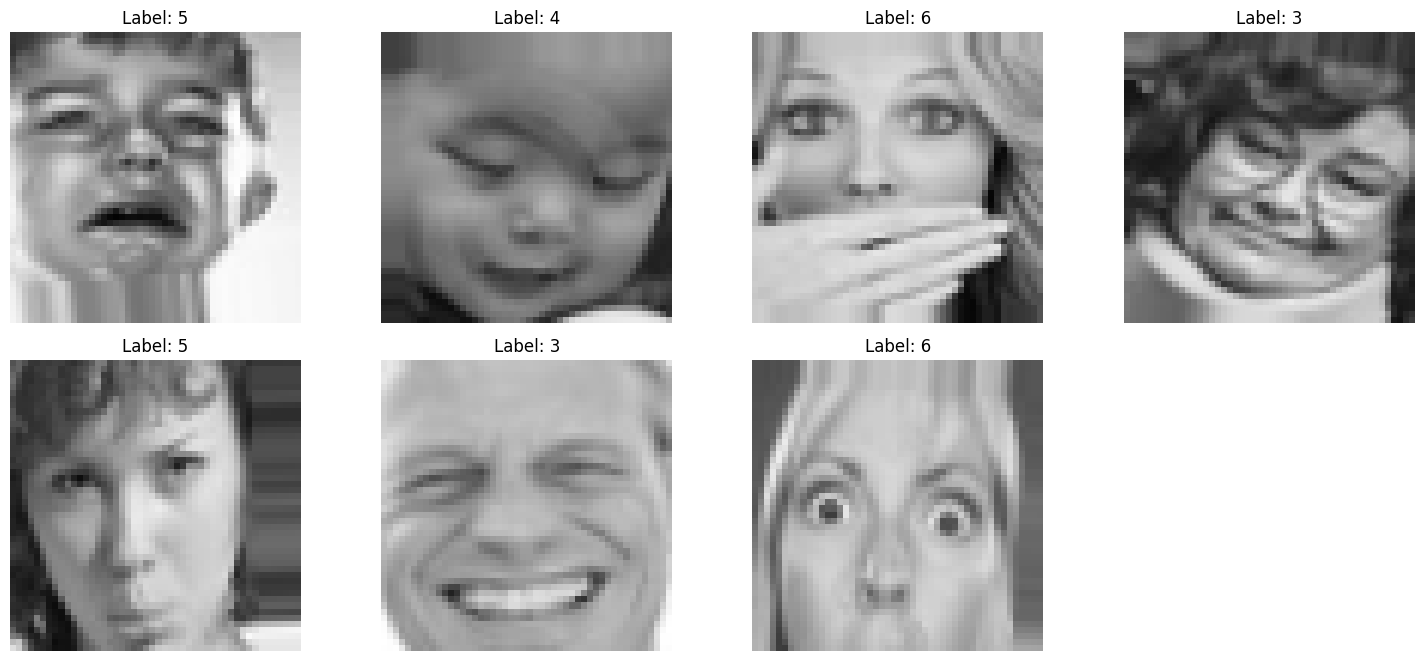

In [37]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with augmentation parameters
train_preprocessor = ImageDataGenerator( 
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Load some sample images from a directory using the ImageDataGenerator
# Replace 'your_train_directory' with the path to your actual training data directory
train_data = train_preprocessor.flow_from_directory(
    r"C:\Users\ELANGO S\project_data\train",
    target_size=(48, 48),  # Assuming 48x48 is the target size for training images
    batch_size=7,  # Number of images to load for visualization
    class_mode='categorical',  # Assuming categorical classification
)

# Get a batch of augmented images
batch_images, batch_labels = next(train_data)

# Plot the augmented images
plt.figure(figsize=(15, 10))
for i in range(len(batch_images)):  # Iterate over images in the batch
    img = batch_images[i]  # Get the ith image from the batch
    label = batch_labels[i]  # Get the corresponding label for the image
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Label: {label.argmax()}')  # Display the label index (assuming one-hot encoding)
    plt.axis('off')

plt.tight_layout()
plt.show()


Found 28709 images belonging to 7 classes.


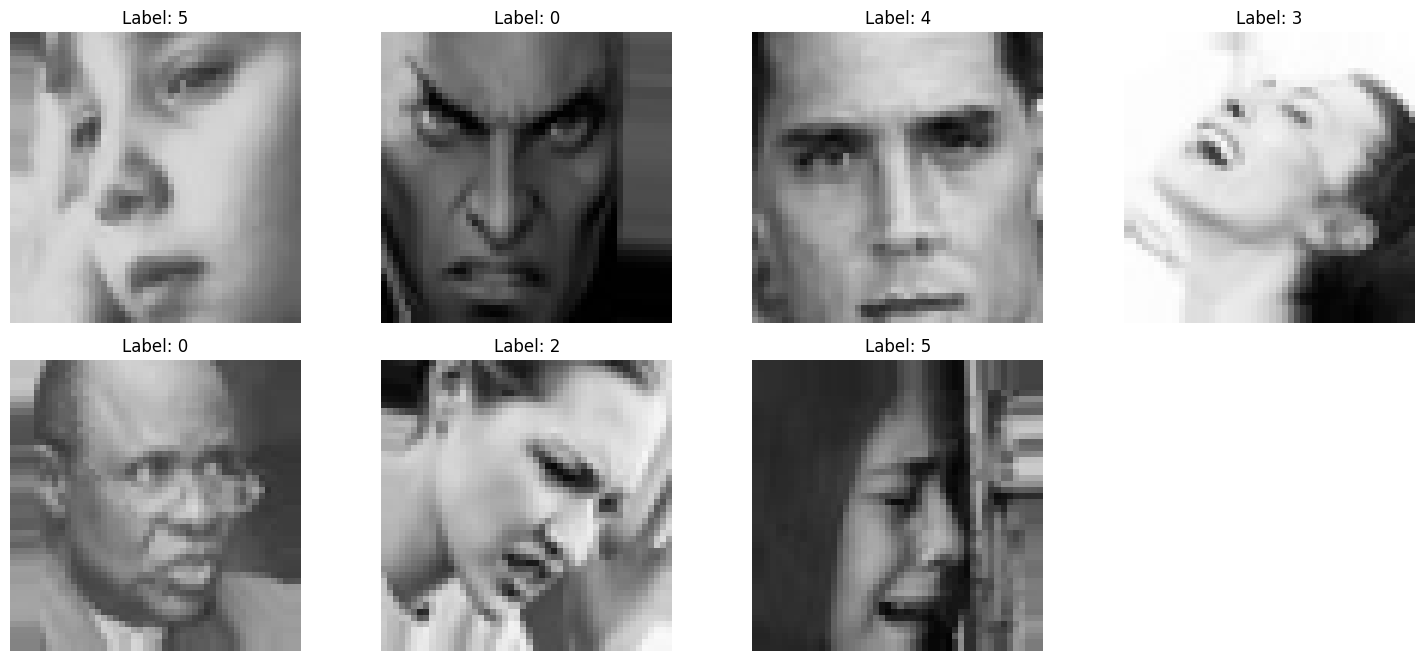

In [40]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with augmentation parameters
train_preprocessor = ImageDataGenerator( 
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Load some sample images from a directory using the ImageDataGenerator
# Replace 'your_train_directory' with the path to your actual training data directory
train_data = train_preprocessor.flow_from_directory(
    r"C:\Users\ELANGO S\project_data\train",
    target_size=(48, 48),  # Assuming 48x48 is the target size for training images
    batch_size=7,  # Number of images to load for visualization
    class_mode='categorical',  # Assuming categorical classification
)

# Get a batch of augmented images
batch_images, batch_labels = next(train_data)

# Plot the augmented images
plt.figure(figsize=(15, 10))
for i in range(len(batch_images)):  # Iterate over images in the batch
    img = batch_images[i]  # Get the ith image from the batch
    label = batch_labels[i]  # Get the corresponding label for the image
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Label: {label.argmax()}')  # Display the label index (assuming one-hot encoding)
    plt.axis('off')

plt.tight_layout()
plt.show()
